In [3384]:
# Make sure you have deepracer-utils >= 0.9

# import sys

# !{sys.executable} -m pip install --upgrade deepracer-utils
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint
import boto3, json

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs.metrics import TrainingMetrics
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [4932]:
# model_logs_root = 'logs/sample-console-logs'
# # log = DeepRacerLog(model_logs_root)

from deepracer.logs import (AnalysisUtils, DeepRacerLog, S3FileHandler)
bucket = "dp123testlocal"

prefixes = ["rl-dp-rf21rogue","rl-dp-rf24rogue-ex","rl-dp-rf18roguex1-ex","rl-dp-rf23rogue-ex-ex","rl-dp-rf20rogue-ex"]

prefix = prefixes[2] # i-099d36eb59fb29baa* 90. fresh. lookahead 8. . no direction (ok but continue)

prefix = prefixes[4] # i-04bbfdfd612181715*. 90. fresh. lookahead 6. direction reward. (wait)
prefix = prefixes[1] # i-0a0819ecc34099f3a* 90. fresh. lookahead 6. direction reward. same of rf20 but little optimized.(wait)

# prefix = prefixes[0] # i-00004a2f6811d7685* (analysis running) 90. fresh. lookahead 6. direction steering reward. (bad)
# prefix = prefixes[3] # i-0717c28263ef143d8* 90. fresh. lookahead 6. only direction. no border logic (bad)


# https://us-east-2.console.aws.amazon.com/systems-manager/session-manager/i-0a0819ecc34099f3a?region=us-east-2#


fh = S3FileHandler(bucket=bucket,prefix=prefix)
log = DeepRacerLog(filehandler=fh)
# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    hyper_params = log.hyperparameters()
    max_episodes = hyper_params["term_cond_max_episodes"]
    pprint(hyper_params)
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()
# simulation_agg = au.simulation_agg(df,secondgroup='unique_episode')
simulation_agg = au.simulation_agg(df)

current_episode = np.max(simulation_agg["episode"])
current_iteration = np.max(simulation_agg['iteration'])

print('Number of episodes = ', current_episode)
print('Number of iterations = ', current_iteration)
# au.analyze_training_progress(simulation_agg, title='Training progress', groupby_field='unique_episode')
# au.analyze_training_progress(simulation_agg, title='Training progress')

Exception: Unable to load logs from folder.

In [4929]:
# View ten best rewarded episodes in the training
result = simulation_agg.nlargest(5, 'progress')
max_result = simulation_agg.nlargest(1, 'iteration')
# result = simulation_agg[simulation_agg["iteration"] == current_iteration].nlargest(10, 'progress')#.nsmallest(5,"time")
top_episodes = list(result["episode"])[:3]
result

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
2512,62,2512,449.0,155,100.0,29.838,71.580375,739.947478,2.559020,739.947478,29.838,739.947478,4th,1
2635,65,2635,422.0,193,100.0,28.045,69.924404,705.747351,2.586256,705.747351,28.045,705.747351,4th,1
2790,69,2790,423.0,130,100.0,28.136,69.677906,717.643203,2.654846,717.643203,28.136,717.643203,5th,1
2812,70,2812,417.0,155,100.0,27.729,70.657790,706.039716,2.697362,706.039716,27.729,706.039716,5th,1
2836,70,2836,429.0,206,100.0,28.530,70.420911,726.924629,2.622378,726.924629,28.530,726.924629,5th,1


Successfully loaded training round 1 for worker 0: Iterations: 85, Training episodes: 3400, Evaluation episodes: 516


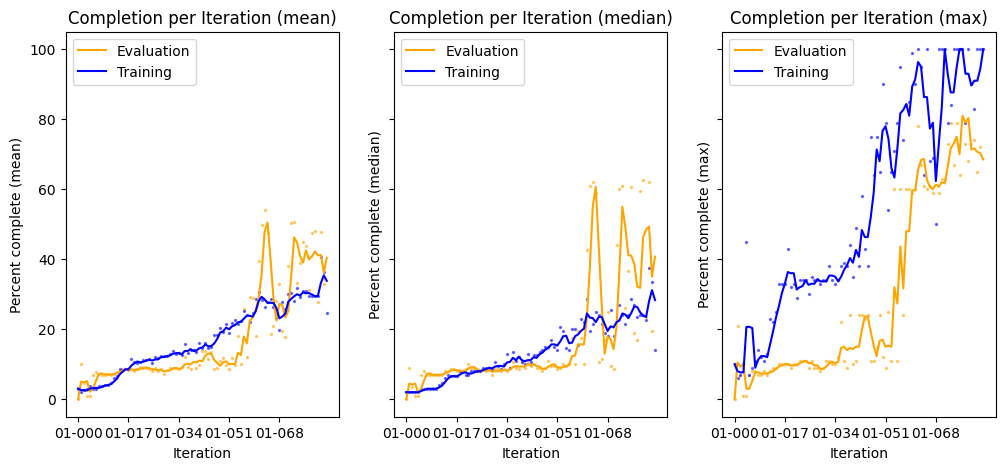

In [4930]:
###### metrics = contents["metrics"]
# evaluation = [v['episode'] // 18 for v in metrics if v["phase"] == "evaluation"]
# print("Completed Evaluations :",len(Counter(evaluation)))
# print(Counter(evaluation))
tm = TrainingMetrics(bucket, prefix)
rounds = np.array([[1,1]])
NUM_ROUNDS = len(rounds)
_ = tm.plotProgress(method=['mean','median','max'],rolling_average=3,rounds=rounds[:,0])

In [4919]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    pass
    # au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [4920]:
# au.scatter_aggregates(complete_ones, 'Stats for all laps')
# complete_ones_last20 = complete_ones[complete_ones['iteration'] >= current_iteration - 10]
# complete_ones_last20
# au.scatter_aggregates(complete_ones_last20, 'Stats for all laps')

In [4921]:
complete_ones.groupby("iteration")['complete'].count()[-7::].sort_index(ascending=False)

iteration
78    4
77    2
76    5
75    3
74    6
71    2
70    1
Name: complete, dtype: int64

In [4922]:
print("Model Name:", prefix)
print("Completed Ones:",len(complete_ones))
print("Completed Ones / Episodes:", 100 * len(complete_ones) / current_episode)
print("Latest Episode:",current_episode, f"({max_episodes})")
select_max = 0
result = complete_ones.nlargest(20, 'iteration')
result = result[(result["iteration"] == current_iteration)].sort_values(by='time',ascending=True)
if not len(result):
    print("** No completion for latest iteration **")
    result = simulation_agg.nlargest(10, 'iteration')
    result = result[(result["iteration"] == current_iteration)].sort_values(by='progress',ascending=False)
    print("Latest Iteration:",list(result.head()["iteration"])[0])
    print("Latest Iteration Best Progress / Time:", list(result.head()["progress"])[0], list(result.head()["time"])[0])
else:
    print("Latest Iteration:",list(result.head()["iteration"])[0])
    print("Latest Iteration Best Time:", list(result.head()["time"])[0])

if select_max:
    pass
else:
    # View five fastest complete laps
    result = complete_ones.nsmallest(10, 'time')
top_episodes = list(result["episode"])[:3]
result

Model Name: rl-dp-rf24rogue
Completed Ones: 25
Completed Ones / Episodes: 0.7913896802785692
Latest Episode: 3159 (20000)
Latest Iteration: 78
Latest Iteration Best Time: 27.458999999998923


,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
3131,78,3131,413.0,142,100.0,27.459,69.248791,673.867417,2.610169,673.867417,27.459,673.867417,5th,1
2964,74,2964,414.0,53,100.0,27.536,68.805866,678.362863,2.637681,678.362863,27.536,678.362863,5th,1
3152,78,3152,424.0,155,100.0,28.197,68.089904,695.226610,2.544811,695.226610,28.197,695.226610,5th,1
2840,71,2840,425.0,1,100.0,28.285,68.710475,689.118345,2.563294,689.118345,28.285,689.118345,5th,1
2966,74,2966,426.0,79,100.0,28.352,69.570570,690.210678,2.590141,690.210678,28.352,690.210678,5th,1
2988,74,2988,428.0,104,100.0,28.470,69.736743,693.139618,2.580374,693.139618,28.470,693.139618,5th,1
3060,76,3060,428.0,1,100.0,28.471,68.743635,694.163480,2.521963,694.163480,28.471,694.163480,5th,1
2589,64,2589,430.0,117,100.0,28.608,69.716295,689.092671,2.596279,689.092671,28.608,689.092671,5th,1
3067,76,3067,431.0,91,100.0,28.732,69.496448,696.600927,2.535963,696.600927,28.732,696.600927,5th,1
3108,77,3108,432.0,104,100.0,28.745,69.438025,688.807523,2.513426,688.807523,28.745,688.807523,5th,1


In [4691]:
# result = complete_ones.nlargest(10, 'reward')
# top_episodes = list(result["episode"])[:3]
# result
# result_ = complete_ones[(complete_ones["start_at"] == 0)]
# result_0

Loaded 258 waypoints


<AxesSubplot:>

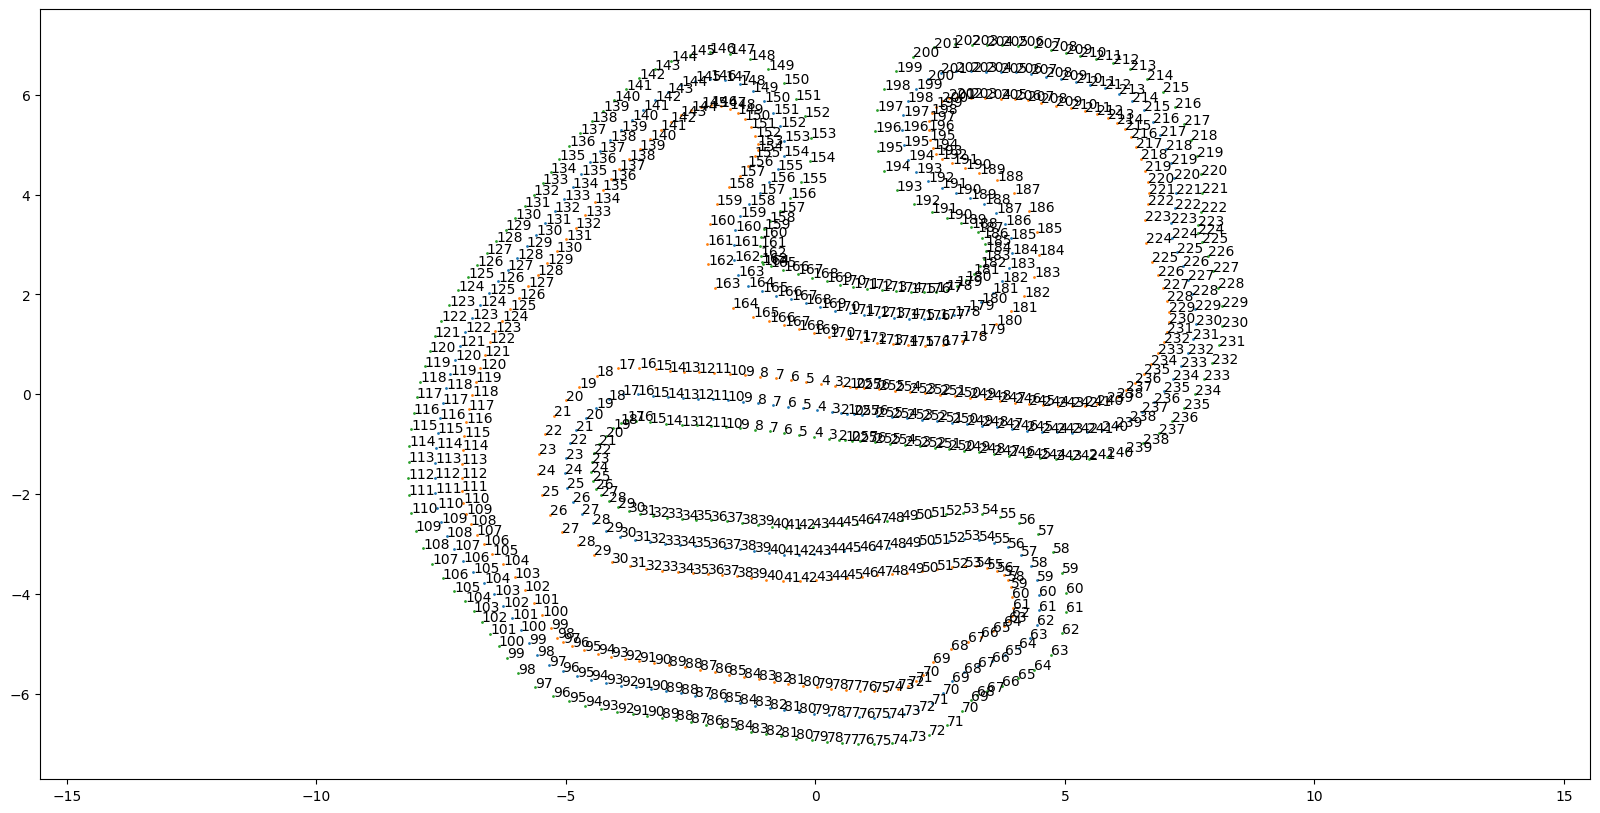

In [4476]:
tu = TrackIO()

for track in tu.get_tracks():
    pass
    # print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

    # We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "reinvent_base"

track_name = "thunder_hill_open.npy"
# track_name = "arctic_pro.npy"
track_name = "jyllandsringen_pro_cw"
track_name = "penbay_open_cw"
track_name = "thunder_hill_pro_cw"
track_name = "2022_june_pro_cw"
track_name = "2022_march_pro_cw"
track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

In [3591]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
# complete_ones = df
# complete_ones = df[df['progress']==100]
# pu.plot_track(complete_ones, track,value_field=7)

### Path taken in a particular episode

[2512, 2635, 2790]


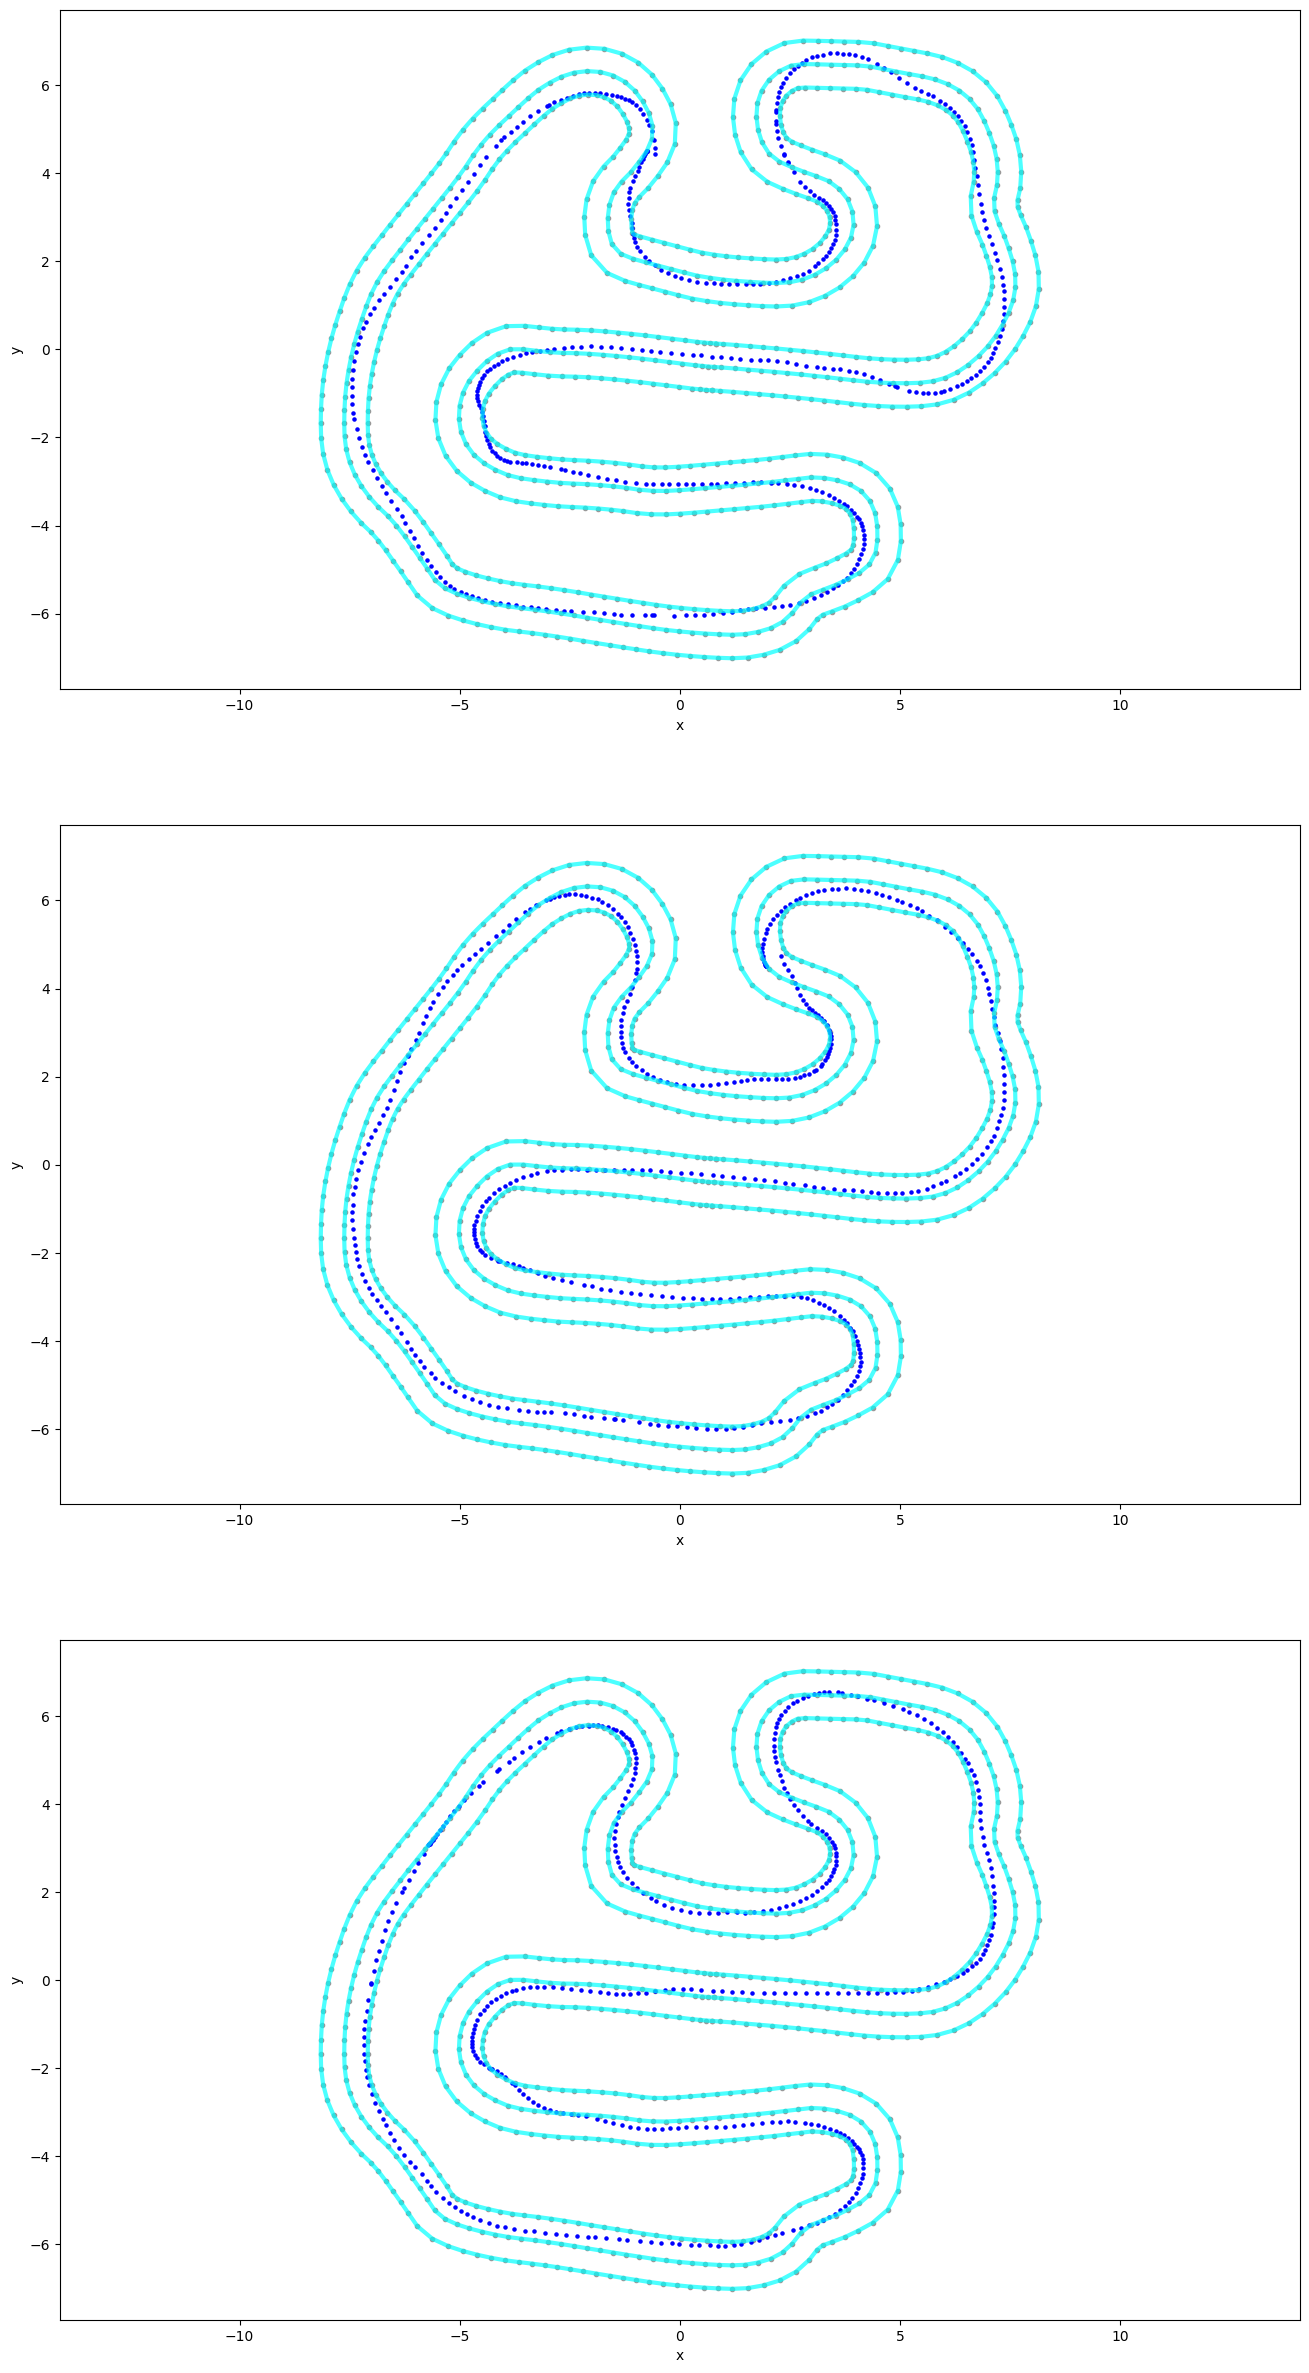

<Figure size 640x480 with 0 Axes>

In [4931]:
episode_id = top_episodes
# episode_id = [3935]
print(episode_id)
# pu.plot_selected_laps(episode_id, df, track,section_to_plot="unique_episode")
pu.plot_selected_laps(episode_id, df, track,section_to_plot="episode")

78


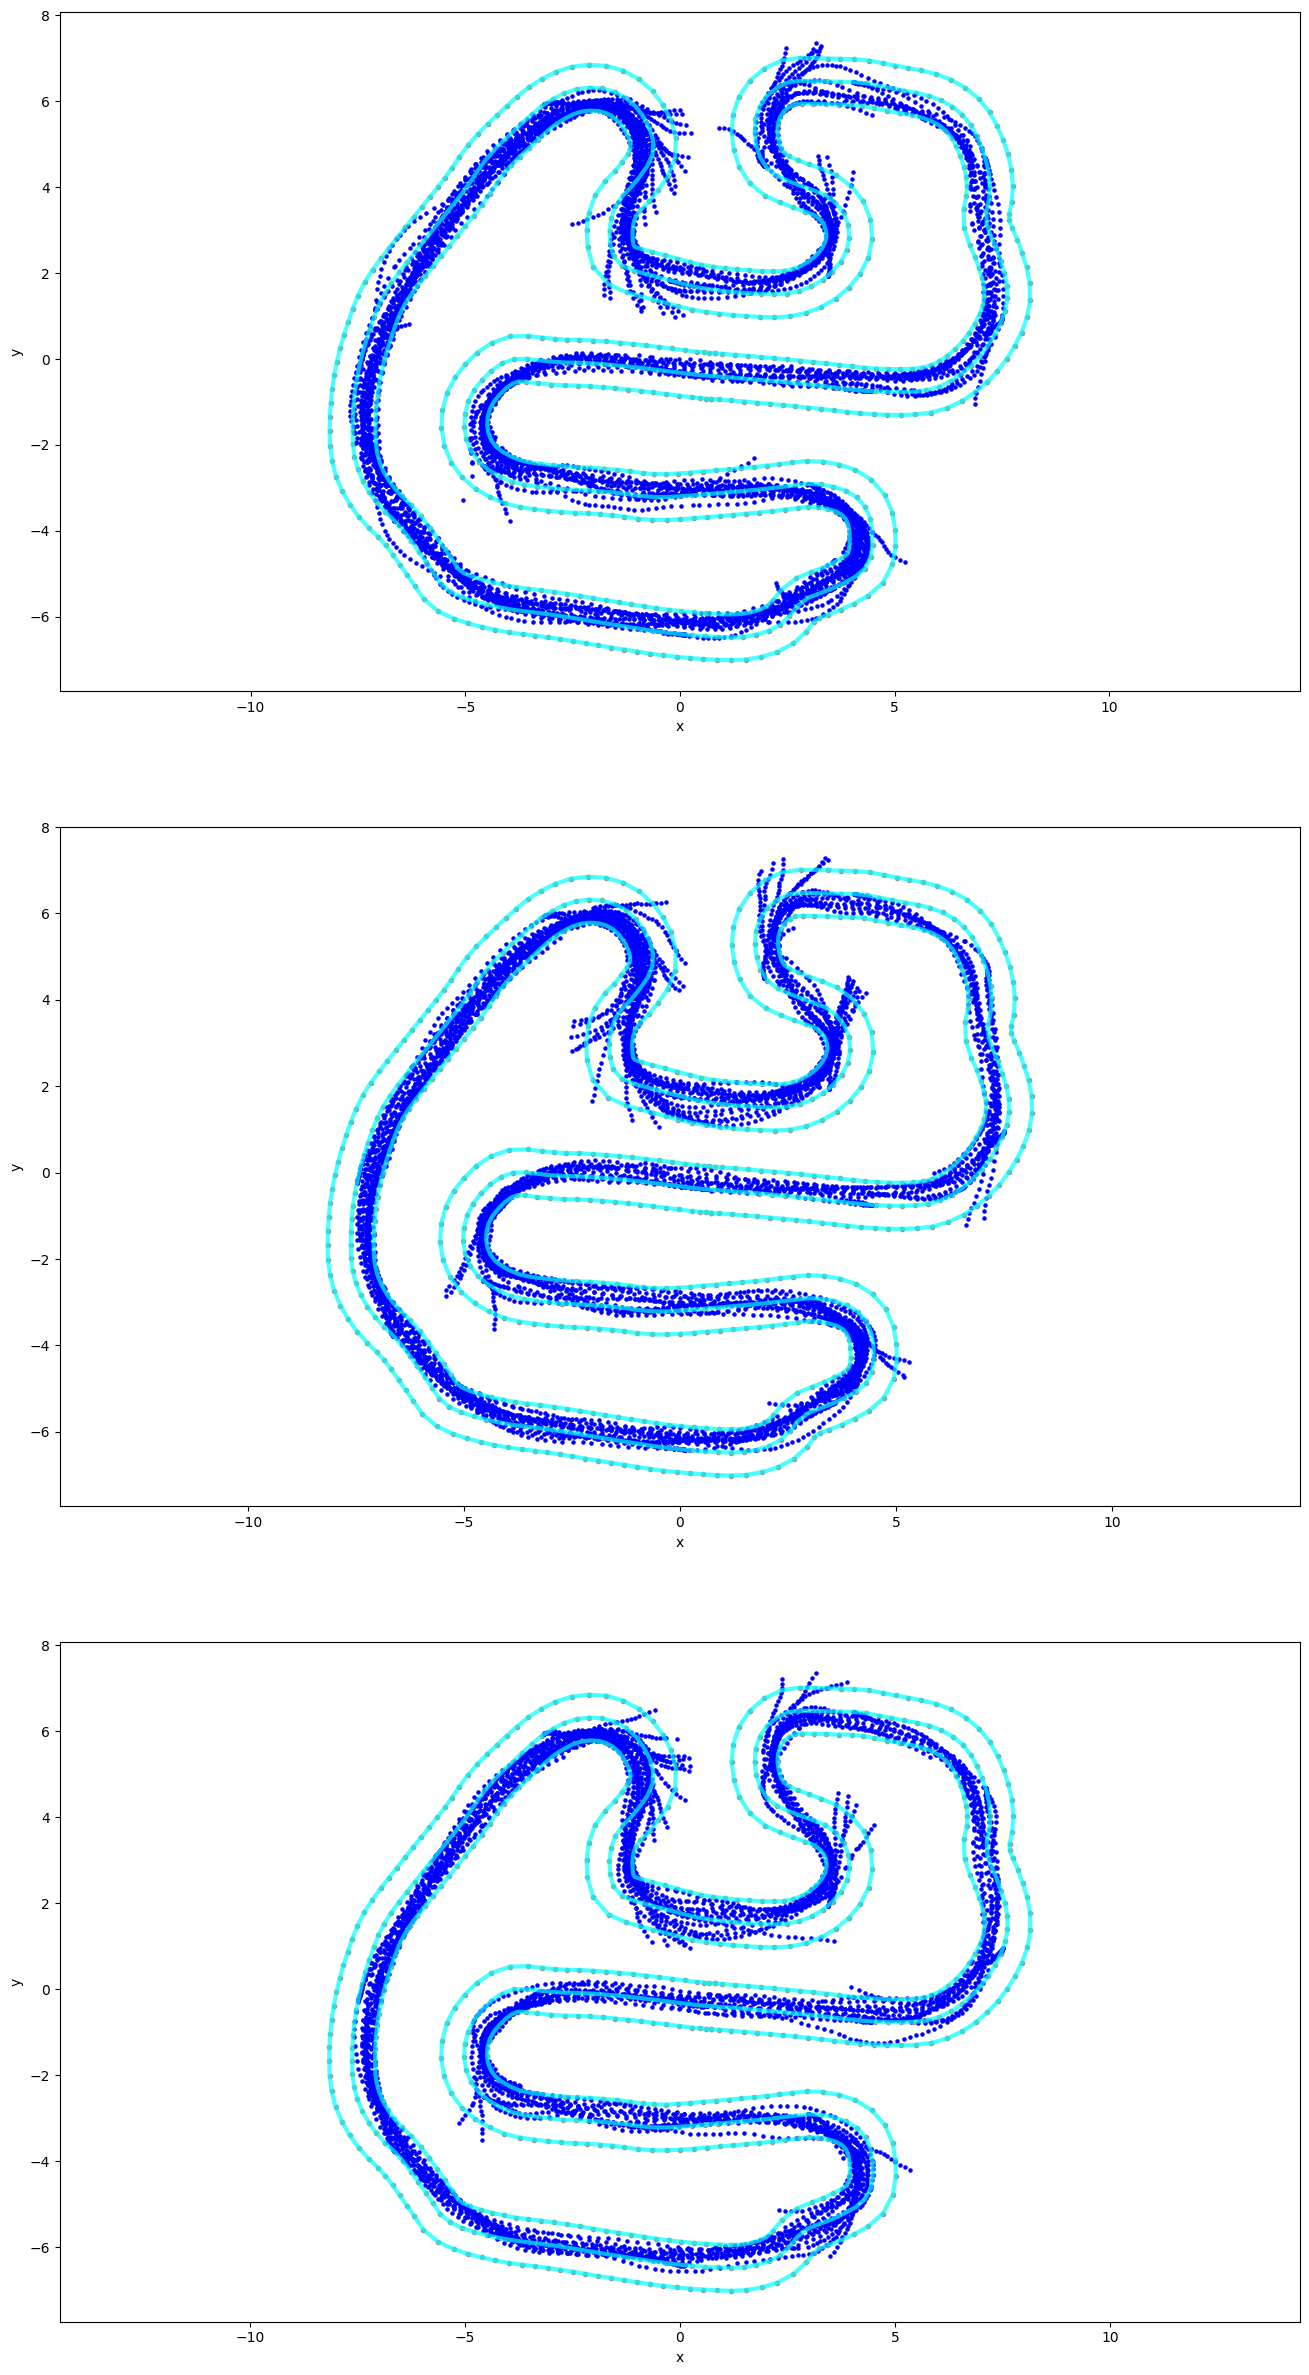

<Figure size 640x480 with 0 Axes>

In [4925]:
iteration_id = current_iteration
# iteration_id = 36
print(iteration_id)
iteration_id = list(range(iteration_id-2,iteration_id+1)) 
iteration_id = iteration_id[::-1]
pu.plot_selected_laps(iteration_id, df, track, section_to_plot = 'iteration')

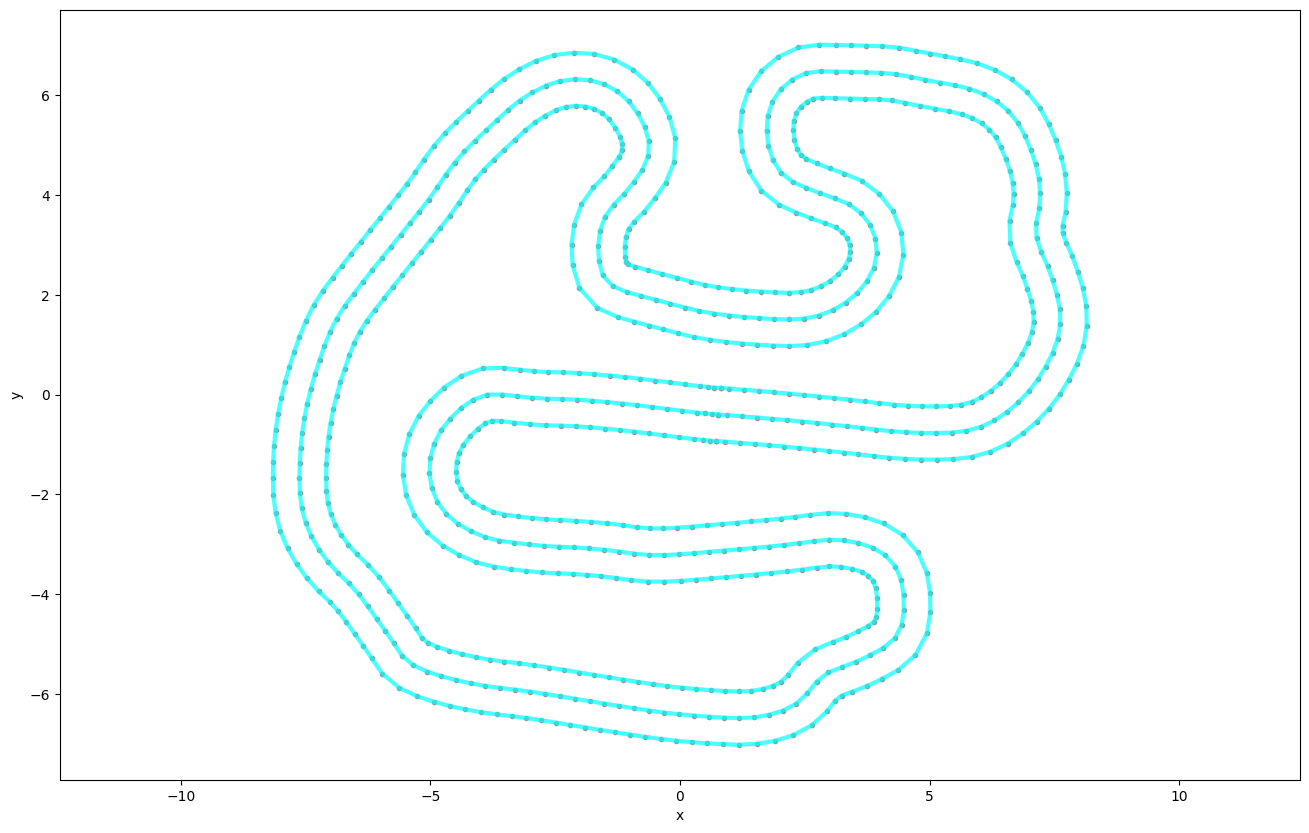

<Figure size 640x480 with 0 Axes>

In [3830]:
com_iteration = complete_ones[(complete_ones["progress"] == 100) & (complete_ones["iteration"] == iteration_id[0])]["episode"]
df_iteration = df[(df["iteration"] == iteration_id[0])]
df_iteration["include"] = df_iteration.apply(lambda x: 1 if x["episode"] in com_iteration else 0, axis=1)
df_iteration = df_iteration[df_iteration["include"] != 0]
pu.plot_selected_laps([iteration_id[0]], df_iteration, track, section_to_plot = 'iteration')

In [ ]:
df_iteration = complete_ones[(complete_ones["progress"] == 100) & (complete_ones["time"].apply(int) == 22)]
df_iteration.sort_values("time", inplace=True)
# df_iteration = df_iteration[(df_iteration["start_at"] != 158) & (df_iteration["start_at"] != 41)]
epis = df_iteration["episode"].to_list()
print(epis)
df_iteration = df.copy()
df_iteration["include"] = df["episode"].isin(epis)
df_iteration = df_iteration[df_iteration["include"] != False]
df_iteration["iteration"] = 0
pu.plot_selected_laps([0], df_iteration, track, section_to_plot = 'iteration')

In [4853]:
##### Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)
ep = 594
# View all steps data for episode 10
df[df['episode']==ep]
# x1 = df[df['episode']==ep]
# x1.to_csv('file1.csv')

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,...,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,new_reward
172883,594,1.0,3.440242,1.945142,39.997804,10.0,2.6,16,0.000000,False,...,0.182664,181,76.746467,13460.573,prepare,0.0,14,0,594,0.000000
172884,594,2.0,3.440125,1.944989,39.962693,20.0,1.8,8,0.450000,False,...,0.182419,181,76.746467,13460.638,in_progress,0.0,14,0,594,0.450000
172885,594,3.0,3.446044,1.952294,40.349567,20.0,1.8,8,0.450000,False,...,0.194444,181,76.746467,13460.700,in_progress,0.0,14,0,594,0.450000
172886,594,4.0,3.457193,1.971875,42.172777,20.0,1.8,8,0.450000,False,...,0.221965,181,76.746467,13460.740,in_progress,0.0,14,0,594,0.450000
172887,594,5.0,3.477333,2.011485,45.797301,20.0,1.8,8,0.450000,False,...,0.275229,181,76.746467,13460.849,in_progress,0.0,14,0,594,0.450000
172888,594,6.0,3.495274,2.058147,50.426121,30.0,2.2,6,0.902231,False,...,0.332197,181,76.746467,13460.900,in_progress,0.0,14,0,594,0.902231
172889,594,7.0,3.509963,2.119121,56.772144,30.0,2.2,6,1.092749,False,...,0.417960,181,76.746467,13460.980,in_progress,0.0,14,0,594,1.092749
172890,594,8.0,3.514848,2.209545,66.880162,20.0,1.8,8,1.272923,False,...,0.512547,181,76.746467,13461.039,in_progress,0.0,14,0,594,1.272923
172891,594,9.0,3.511055,2.298167,75.682625,10.0,2.2,14,1.633513,False,...,0.598091,182,76.746467,13461.111,in_progress,0.0,14,0,594,1.633513
172892,594,10.0,3.506902,2.409890,82.311611,10.0,2.8,18,2.055317,False,...,0.706460,182,76.746467,13461.169,in_progress,0.0,14,0,594,2.055317


In [ ]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)
iteration = 7
waypoint_start = 0
waypoint_end = 9999
# View all steps data for episode 10
# df_new = df[(df['iteration']==iteration) & (df['closest_waypoint'] >= waypoint_start) & (df['closest_waypoint'] <= waypoint_end)]
# df_new.groupby(["closest_waypoint","speed","steering_angle"])["reward"].sum()

# x1 = df[(df['episode']==9486) | (df['episode']==7225) | (df['episode']==7524)]
# x1 = df[(df['episode']==30)]
x1 = df[(df['iteration']==97)]
x1.groupby(["speed","steering_angle"])["reward"].count()
# x1.to_csv('file1.csv')

In [ ]:
episode_id = [ep]
closest_waypoint = 67
df_temp = df[(df["closest_waypoint"] == closest_waypoint) & (df["episode"] == episode_id[0])]
df_temp

In [ ]:
pu.plot_selected_laps(episode_id, df_temp, track,section_to_plot="episode")

In [ ]:
track_breakdown.keys()

In [ ]:
abu.action_breakdown(df, track, track_breakdown=track_breakdown.get('reinvent2018'), episode_ids=[2564])

In [ ]:
import time
from IPython.display import clear_output

for i in range(10):
    model_data = []
    for prefix in prefixes:
        fh = S3FileHandler(bucket=bucket,prefix=prefix)
        log = DeepRacerLog(filehandler=fh)
        # load logs into a dataframe
        log.load()

        try:
            hyper_params = log.hyperparameters()
            max_episodes = hyper_params["term_cond_max_episodes"]
        except Exception:
            print("Robomaker logs not available")

        df = log.dataframe()
        # simulation_agg = au.simulation_agg(df,secondgroup='unique_episode')
        simulation_agg = au.simulation_agg(df)

        current_episode = np.max(simulation_agg["episode"])
        current_iteration = np.max(simulation_agg['iteration'])
        model_data.append([prefix, f"{current_episode}/{max_episodes}"])
    clear_output(wait=True)
    [print(i) for i in model_data]
    time.sleep(300)
    